# Team River
## Members: Ana Navarro, Douglas Li, Eva Mai, Henry Lam, Phillip Martinez
### CSC621/821
### Spring 2022

In [1]:
from myshow import myshow, myshow3d
import SimpleITK as sitk
import registration_gui as rgui
%matplotlib notebook
import gui
import numpy as np
import matplotlib.pyplot as plt

## REGISTRATION

<IPython.core.display.Javascript object>


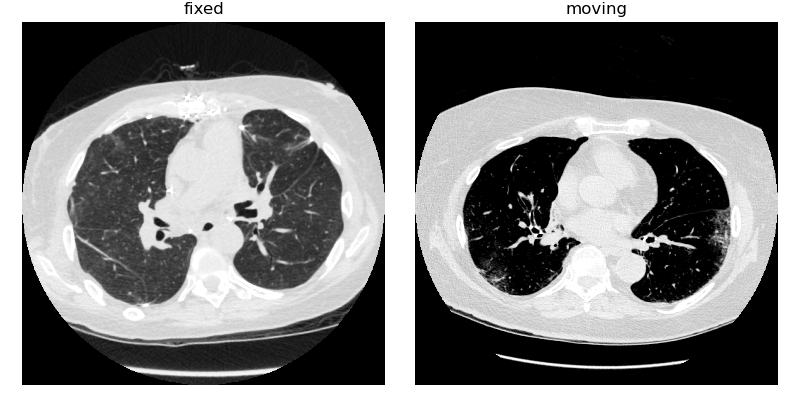

In [2]:
img1 = sitk.ReadImage('/Users/eva/Desktop/manifest-1648618045475/3DImage_1B_000340.mha', sitk.sitkFloat32)#Healthy Lung
img2 = sitk.ReadImage('/Users/eva/Desktop/manifest-1648618045475/3DImage_26970.mha', sitk.sitkFloat32)#Infected Lung

fixed_image = img1 #Healty Lung
moving_image = img2 #Infected Lung
gui.MultiImageDisplay(image_list = [fixed_image, moving_image],                   
                      title_list = ['fixed', 'moving'], figure_size=(8,4));

### Initialization

<IPython.core.display.Javascript object>


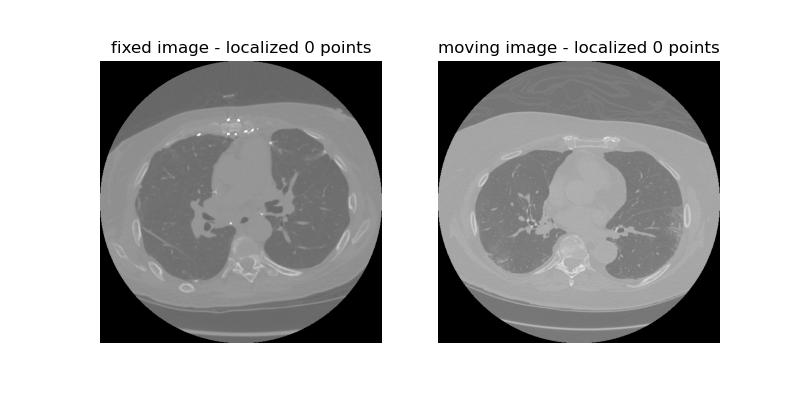

In [3]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

gui.RegistrationPointDataAquisition(fixed_image, moving_image, figure_size=(8,4), known_transformation=initial_transform);

In [4]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=100)
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
registration_method.SetMetricSamplingPercentage(1)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [6,4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[3,2,1,0])

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace= False)

final_transform = registration_method.Execute(fixed_image, moving_image)

# Always check the reason optimization terminated.
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.33302454858058755
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


Qualitatively evaluate the result using a linked cursor approach (visual evaluation):

<IPython.core.display.Javascript object>


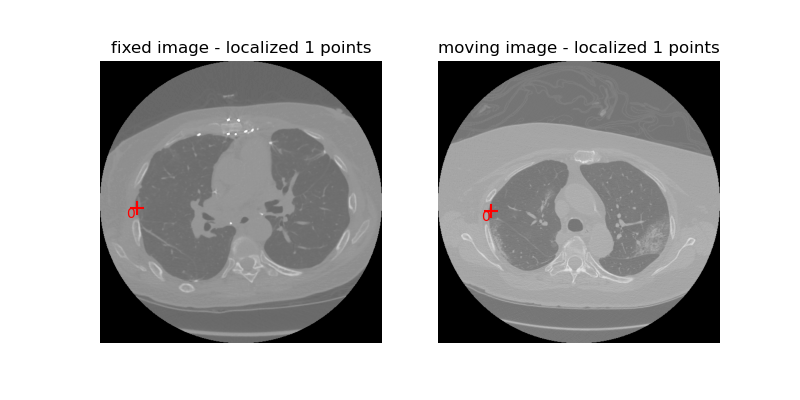

In [5]:
gui.RegistrationPointDataAquisition(fixed_image, moving_image, figure_size=(8,4), known_transformation=final_transform);

In [6]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
#Enable the following line to save the image
#sitk.WriteImage(moving_resampled, 'resampled_registered_lung_infected.mha')

In [7]:
myshow(moving_resampled)

interactive(children=(IntSlider(value=107, description='z', max=215), Output()), _dom_classes=('widget-interac…

## Segmentation

<IPython.core.display.Javascript object>


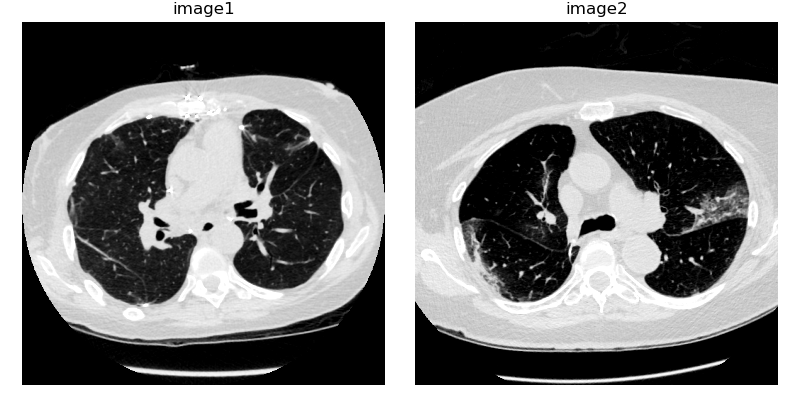

In [9]:
#Import image

img11 = img1 #Healthy Lung
img22 = moving_resampled #Infected Lung

#Display Initial Image
gui.MultiImageDisplay(image_list = [img11, img22],                   
                      title_list = ['image1', 'image2'],
                      figure_size=(8,4));

<IPython.core.display.Javascript object>


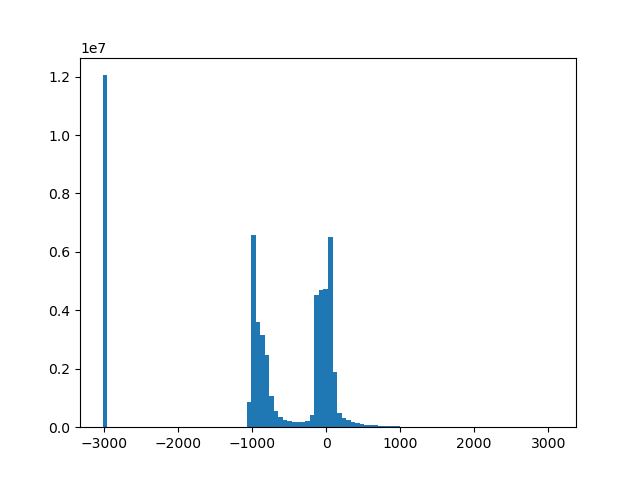

<IPython.core.display.Javascript object>


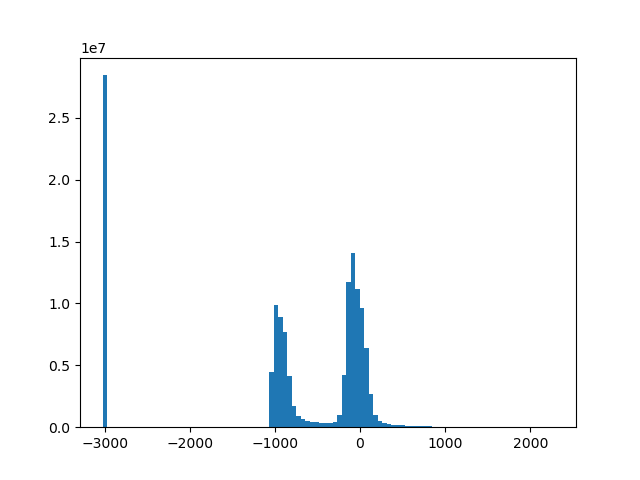

In [10]:
#Display histogram for image 1
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(img1).flatten(), bins=100)
plt.show()

#Display histogram for image 2
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(img2).flatten(), bins=100)
plt.show()

In [11]:
seg_img1 = sitk.BinaryThreshold(img11, lowerThreshold=-1500, upperThreshold=-370, insideValue=0, outsideValue=1)
myshow(seg_img1)
seg_img2 = sitk.BinaryThreshold(img22, lowerThreshold=-1500, upperThreshold=-370, insideValue=0, outsideValue=1)
myshow(seg_img2)

interactive(children=(IntSlider(value=107, description='z', max=215), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=107, description='z', max=215), Output()), _dom_classes=('widget-interac…

In [14]:
#Using ConfidenceConnected

seed1 = (170, 200, 107)
seg1 = sitk.ConfidenceConnected(
    seg_img1,
    seedList=[seed1],
    numberOfIterations=1,
    multiplier=2.5,
    initialNeighborhoodRadius=1,
    replaceValue=1,
)

seed2 = (170, 280, 127)
seg2 = sitk.ConfidenceConnected(
    seg_img2,
    seedList=[seed2],
    numberOfIterations=1,
    multiplier=2.5,
    initialNeighborhoodRadius=1,
    replaceValue=1,
)

myshow(seg1)
myshow(seg2)

interactive(children=(IntSlider(value=107, description='z', max=215), Output()), _dom_classes=('widget-interac…

interactive(children=(IntSlider(value=107, description='z', max=215), Output()), _dom_classes=('widget-interac…

<IPython.core.display.Javascript object>


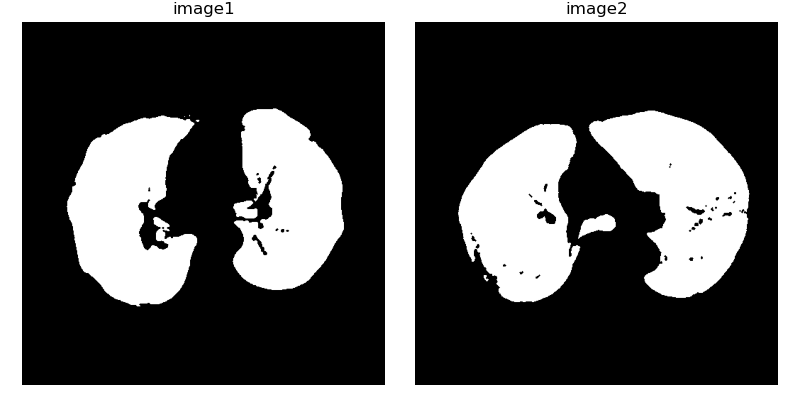

In [15]:
#Morphological
vectorRadius = (1, 1, 1)
kernel = sitk.sitkBall

seg_implicit_thresholds_clean_1 = sitk.BinaryMorphologicalClosing(
    seg1, vectorRadius, kernel
)
seg_implicit_thresholds_clean_2 = sitk.BinaryMorphologicalClosing(
    seg2, vectorRadius, kernel
)
gui.MultiImageDisplay(image_list = [seg_implicit_thresholds_clean_1, seg_implicit_thresholds_clean_2],                   
                      title_list = ['image1', 'image2'],
                      figure_size=(8,4));

### Overlay segmentation result with original image

In [16]:
overlay_1 = sitk.Cast(seg_implicit_thresholds_clean_1, sitk.sitkFloat32) * sitk.InvertIntensity(img11)
overlay_2 = sitk.Cast(seg_implicit_thresholds_clean_2, sitk.sitkFloat32) * sitk.InvertIntensity(img22)

<IPython.core.display.Javascript object>


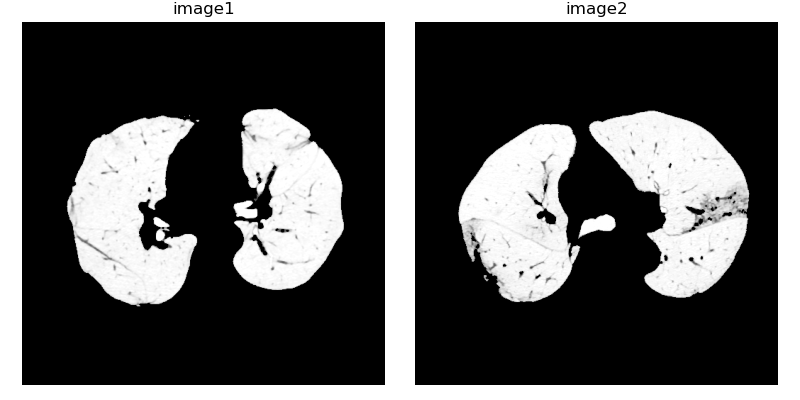

In [17]:
gui.MultiImageDisplay(image_list = [overlay_1, overlay_2],                   
                      title_list = ['image1', 'image2'],
                      figure_size=(8,4));

## Histogram Equalization

<IPython.core.display.Javascript object>


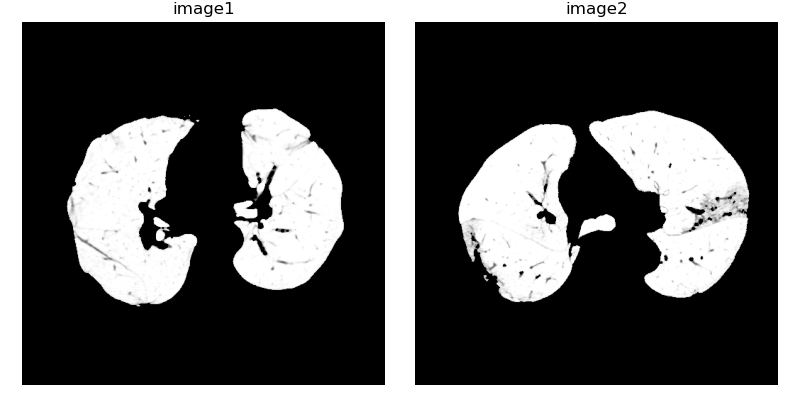

In [18]:
img1_4095 = sitk.Cast(sitk.IntensityWindowing(overlay_1, windowMinimum=0, windowMaximum=1058, 
                                             outputMinimum=0.0, outputMaximum=4095.0), sitk.sitkInt32)
img2_4095 = sitk.Cast(sitk.IntensityWindowing(overlay_2, windowMinimum=0, windowMaximum=1058, 
                                             outputMinimum=0.0, outputMaximum=4095.0), sitk.sitkInt32)
    
#Display windowed Image
gui.MultiImageDisplay(image_list = [img1_4095, img2_4095],                   
                      title_list = ['image1', 'image2'],
                      figure_size=(8,4));

<IPython.core.display.Javascript object>


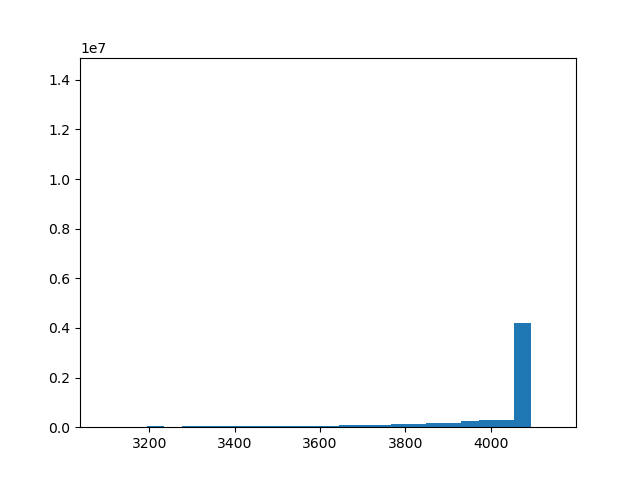

<IPython.core.display.Javascript object>


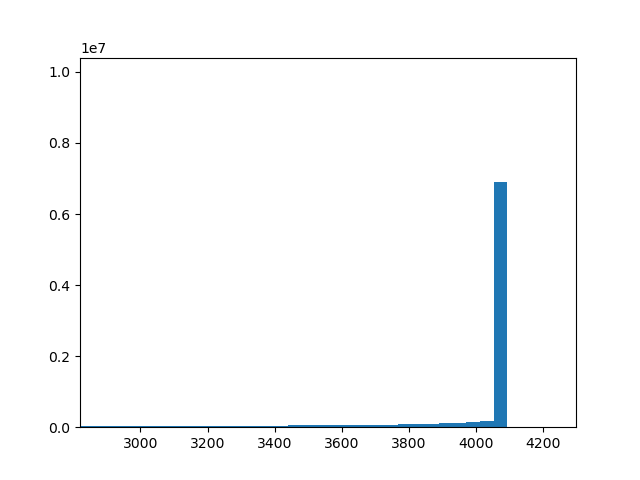

In [26]:
#Display histogram for image 1
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(img1_4095).flatten(), bins=100)
plt.show()

#Display histogram for image 2
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(img2_4095).flatten(), bins=100)
plt.show()

In [ ]:
test1 = sitk.AdaptiveHistogramEqualization(img1_4095)
test2 = sitk.AdaptiveHistogramEqualization(img2_4095)
#Display windowed Image
gui.MultiImageDisplay(image_list = [test1, test2],                   
                      title_list = ['image1', 'image2'],
                      figure_size=(8,4));

<IPython.core.display.Javascript object>


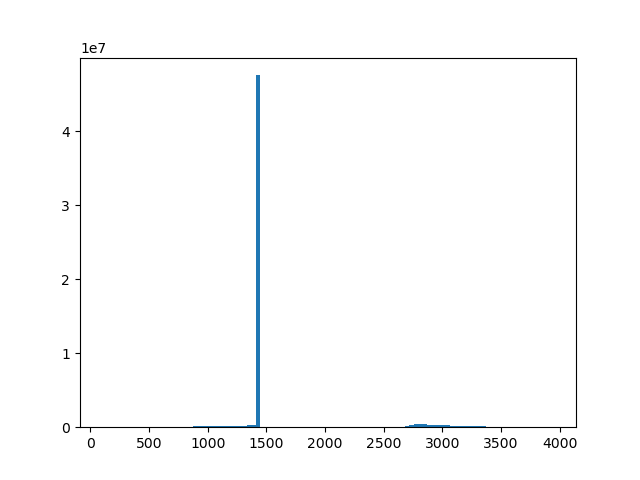

<IPython.core.display.Javascript object>


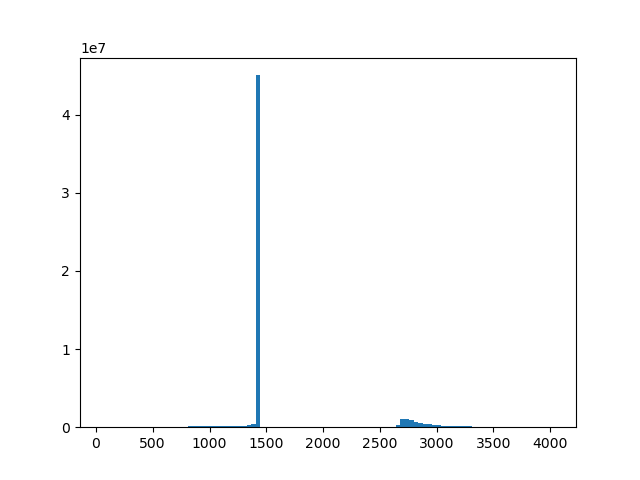

In [28]:
#Display histogram for image 1
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(test1).flatten(), bins=100)
plt.show()

#Display histogram for image 2
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(test2).flatten(), bins=100)
plt.show()